In [1]:
import os
import librosa
import numpy as np
import pandas as pd

# Chemin vers les fichiers (adapter si besoin)
DATA_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"

genres = os.listdir(DATA_PATH)
genres = [g for g in genres if os.path.isdir(os.path.join(DATA_PATH, g))]
print("Genres:", genres)


Genres: ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [2]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
    features = {}

    # Découpe en frames
    frame_length = 2048
    hop_length = 512

    # Features par frame
    features["zcr"] = np.mean(librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length))
    features["rms"] = np.mean(librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length))
    features["centroid"] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length))
    features["bandwidth"] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length))
    features["rolloff"] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length))
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(1, 14):
        features[f"mfcc{i}"] = np.mean(mfccs[i-1])
    
    return features


In [5]:
data = []

for genre in genres:
    folder = os.path.join(DATA_PATH, genre)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            try:
                features = extract_features(path)
                features["label"] = genre
                data.append(features)
            except Exception as e:
                print(f"❌ Erreur avec {file} — ignoré : {type(e).__name__} - {str(e)}")

print(f"✅ Extraction terminée : {len(data)} fichiers valides")


/tmp/ipykernel_35/3313456524.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


❌ Erreur avec jazz.00054.wav — ignoré : NoBackendError - 
✅ Extraction terminée : 999 fichiers valides


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Séparation des features et des labels
X = pd.DataFrame(data).drop("label", axis=1)
y = pd.DataFrame(data)["label"]

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


--- Random Forest ---
              precision    recall  f1-score   support

       blues       0.56      0.70      0.62        20
   classical       0.78      0.90      0.84        20
     country       0.61      0.70      0.65        20
       disco       0.45      0.45      0.45        20
      hiphop       0.46      0.30      0.36        20
        jazz       0.39      0.35      0.37        20
       metal       0.68      0.65      0.67        20
         pop       0.58      0.75      0.65        20
      reggae       0.59      0.50      0.54        20
        rock       0.50      0.40      0.44        20

    accuracy                           0.57       200
   macro avg       0.56      0.57      0.56       200
weighted avg       0.56      0.57      0.56       200



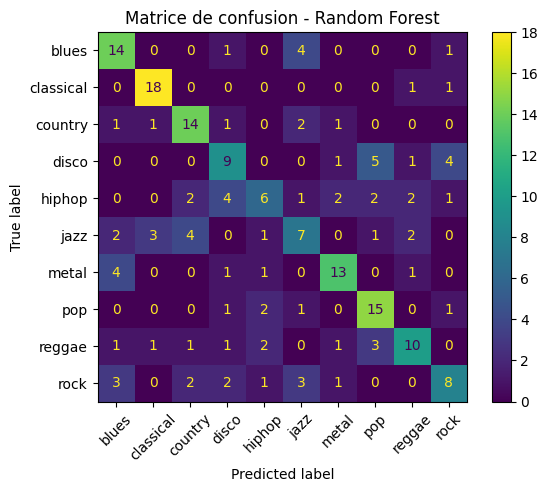

--- SVM ---
              precision    recall  f1-score   support

       blues       0.62      0.65      0.63        20
   classical       0.83      0.95      0.88        20
     country       0.54      0.65      0.59        20
       disco       0.62      0.65      0.63        20
      hiphop       0.65      0.55      0.59        20
        jazz       0.53      0.50      0.51        20
       metal       0.89      0.80      0.84        20
         pop       0.71      0.75      0.73        20
      reggae       0.56      0.45      0.50        20
        rock       0.55      0.55      0.55        20

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200



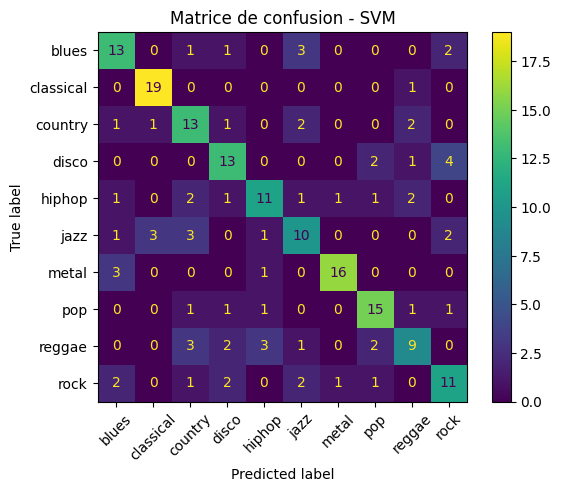

--- k-NN ---
              precision    recall  f1-score   support

       blues       0.48      0.50      0.49        20
   classical       0.72      0.90      0.80        20
     country       0.45      0.75      0.57        20
       disco       0.60      0.60      0.60        20
      hiphop       0.31      0.20      0.24        20
        jazz       0.40      0.50      0.44        20
       metal       0.73      0.55      0.63        20
         pop       0.57      0.65      0.60        20
      reggae       0.62      0.40      0.48        20
        rock       0.58      0.35      0.44        20

    accuracy                           0.54       200
   macro avg       0.55      0.54      0.53       200
weighted avg       0.55      0.54      0.53       200



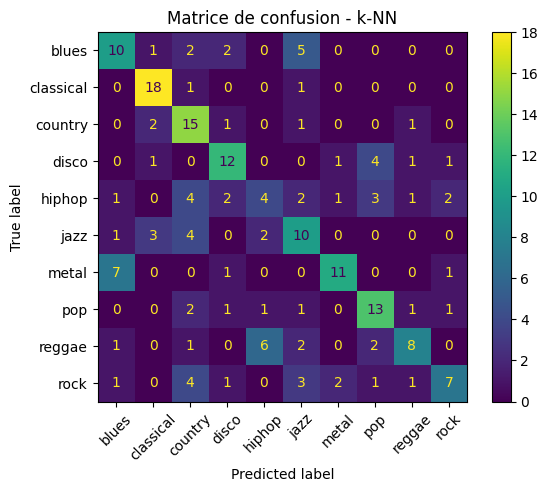

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Modèles
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=10, gamma='scale'),
    "k-NN": KNeighborsClassifier(n_neighbors=5)
}

# Entraînement et évaluation
for name, model in models.items():
    print(f"--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, xticks_rotation=45)
    plt.title(f"Matrice de confusion - {name}")
    plt.grid(False)
    plt.show()


SVM > RandomForest > k-NN

Meilleure performance avec SVM :

Accuracy ≈ 65%

Bonne précision sur classical, country, jazz

Les genres comme hiphop et rock sont souvent mal classés, probablement à cause de similarités acoustiques.

In [21]:
import librosa
import numpy as np

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
    features = {}

    # Paramètres
    frame_length = 2048
    hop_length = 512

    # 1. ZCR, RMS, Centroid, Bandwidth, Rolloff
    features["zcr"] = np.mean(librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length))
    features["rms"] = np.mean(librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length))
    features["centroid"] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length))
    features["bandwidth"] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length))
    features["rolloff"] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length))

    # 2. MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f"mfcc{i+1}"] = np.mean(mfccs[i])

    # 3. Dérivées de MFCCs (delta)
    mfccs_delta = librosa.feature.delta(mfccs)
    for i in range(13):
        features[f"mfcc_delta{i+1}"] = np.mean(mfccs_delta[i])

    # 4. Chroma (moyenne et variance)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features["chroma_mean"] = np.mean(chroma)
    features["chroma_var"] = np.var(chroma)

    return features


In [22]:
data = []

for genre in genres:
    folder = os.path.join(DATA_PATH, genre)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            try:
                features = extract_features(path)
                features["label"] = genre
                data.append(features)
            except Exception as e:
                print(f"Erreur avec {file} : {e}")


/tmp/ipykernel_35/763744538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erreur avec jazz.00054.wav : 


In [23]:
df = pd.DataFrame(data)

# Afficher les 5 premières lignes
print("✅ Aperçu du DataFrame avec features enrichies :")
df.head()

✅ Aperçu du DataFrame avec features enrichies :


,zcr,rms,centroid,bandwidth,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc_delta7,mfcc_delta8,mfcc_delta9,mfcc_delta10,mfcc_delta11,mfcc_delta12,mfcc_delta13,chroma_mean,chroma_var,label
0,0.173815,0.115748,3257.126965,2898.084210,6681.101267,-66.568810,58.310619,-8.179027,15.493415,5.575189,...,0.003590,-0.003719,-0.000800,-0.005446,-0.002166,0.004716,-0.007305,0.417176,0.083845,disco
1,0.111870,0.100276,2129.345892,2109.251346,4424.306580,-114.932045,113.463867,-29.804312,42.612103,-10.326010,...,-0.012875,-0.014308,-0.017985,-0.001037,-0.009557,-0.008283,-0.000565,0.429884,0.078041,disco
2,0.099815,0.084770,2292.577701,2348.189625,5038.611199,-154.623306,97.932602,-10.357320,39.123672,-11.213964,...,0.003691,0.007374,0.000864,0.010062,0.010284,0.020706,0.005497,0.453016,0.086783,disco
3,0.150862,0.169954,3168.111241,3047.644241,6935.358063,-40.729237,63.947403,4.904890,16.340809,12.100067,...,0.005083,0.007322,0.007983,-0.000011,-0.008405,-0.003446,0.002535,0.450306,0.079827,disco
4,0.093033,0.114499,1975.227458,2090.041185,4251.482625,-121.095222,116.942497,-22.786970,45.148933,-4.239051,...,-0.011356,-0.005776,-0.012839,-0.002027,-0.004459,-0.002874,-0.008345,0.434843,0.079384,disco


In [13]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

def generate_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)  # format 224x224 pour CNN
    plt.axis('off')
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    image = Image.open(buf).convert('RGB').resize((128, 128))
    return np.array(image)


In [14]:
X_img = []
y_img = []

for genre in genres:
    folder = os.path.join(DATA_PATH, genre)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            try:
                path = os.path.join(folder, file)
                img = generate_mel_spectrogram(path)
                X_img.append(img)
                y_img.append(genre)
            except Exception as e:
                print(f"Erreur avec {file} : {e}")


/tmp/ipykernel_35/211775806.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erreur avec jazz.00054.wav : 


In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_img = np.array(X_img)
y_img = np.array(y_img)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_img)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_img, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42)


2025-06-03 19:40:57.893846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748979658.099990      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748979658.157652      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modèle CNN allégé avec régularisation
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 genres
])

# Compilation
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()

# Callback : arrêt si val_loss ne diminue plus
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 827,562 (3.16 MB)

 Trainable params: 827,338 (3.16 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.2080 - loss: 3.0944 - val_accuracy: 0.1000 - val_loss: 2.3251
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2652 - loss: 2.0492 - val_accuracy: 0.1000 - val_loss: 2.3486
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3285 - loss: 1.9660 - val_accuracy: 0.1000 - val_loss: 2.2179
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3780 - loss: 1.8034 - val_accuracy: 0.2450 - val_loss: 2.0511
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3579 - loss: 1.6895 - val_accuracy: 0.2250 - val_loss: 2.1614
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4406 - loss: 1.5315 - val_accuracy: 0.3700 - val_loss: 1.8744
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4709 - loss: 1.4487 - val_accuracy: 0.4100 - val_loss: 1.7455
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4718 - loss: 1.3989 - val_accuracy: 0.4650 -

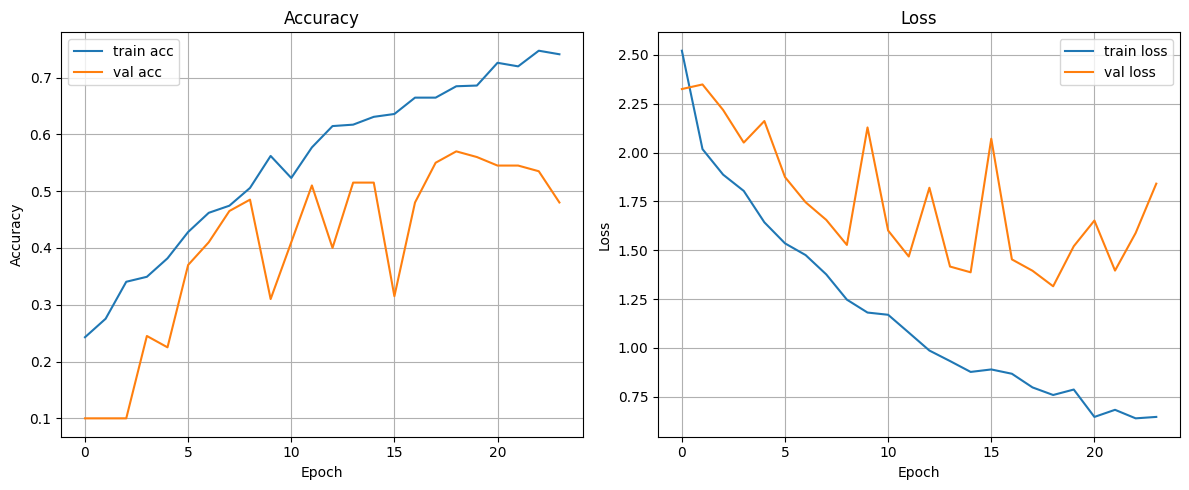

In [25]:
# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Train accuracy : très bonne (> 70%)

Validation accuracy : plafonne à ~55-58% → montre un début d’overfitting

Validation loss augmente parfois → EarlyStopping est utile